## Create map
* OSM map features: https://wiki.openstreetmap.org/wiki/Map_features

### Packages

In [43]:
# Packages
import contextily as cx
from folium import Map, LayerControl
from folium.plugins import LocateControl
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
from shapely.geometry import box

### Functions

In [44]:
# Functions
def buffer_aoi(gdf_aoi, buffer=1000):
    # Reproject to EPSG:3857
    crs = gdf_aoi.crs
    gdf_aoi = gdf_aoi.to_crs('EPSG:3857')

    # Buffer area of interest
    gdf_aoi['geometry'] = gdf_aoi.buffer(buffer)

    # Reproject back to original crs
    gdf_aoi = gdf_aoi.to_crs(crs)
    
    # Return buffered aoi
    return gdf_aoi

def features_from_aoi(gdf_aoi, tags, clip='false'):
    # Get bounds
    bounds = gdf_aoi.total_bounds

    # Get features from bbox
    try:
        gdf_features = ox.features_from_bbox(bounds, tags)
    except ox._errors.InsufficientResponseError:
        gdf_features = gpd.GeoDataFrame(columns=['geometry'], crs=gdf_aoi.crs)
    
    # Clip features to bbox
    if clip == 'aoi':
        gdf_features = gdf_features.clip(gdf_aoi)
    if clip == 'box':
        gdf_features = gdf_features.cx[bounds[0]:bounds[2], bounds[1]:bounds[3]]
        
    # Return features
    return gdf_features

### Settings

In [49]:
# Define geographic area of interest
geocode_aoi = "Rotterdam, Netherlands"

# Define colour palette
colours = {'aoi': 'black',
           'suburb': 'grey',
           'train': '#D63333',
           'metro': '#5665EB',
           'light_rail': '#4FB26D',
           'tram': '#E47A3E'}

### Get assests

In [50]:
# Get area of interest
gdf_aoi = ox.geocode_to_gdf(geocode_aoi)

# Get buffered area of interest
gdf_buffer = buffer_aoi(gdf_aoi, buffer=500)

# Get bounding box
gdf_bbox = gpd.GeoDataFrame(data={'geometry': [box(*gdf_buffer.total_bounds)], 'name': ['bbox']}, crs=gdf_buffer.crs)

# Get bounds, centre, width and height
bounds = gdf_bbox.total_bounds
centre = (bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2
width = (bounds[2] - bounds[0])
height = bounds[3] - bounds[1]

# Get aspect ratio from plot
fig, ax = plt.subplots(figsize=(width/100, height/100))
gdf_buffer.boundary.plot(ax=ax)
aspect_ratio = ax.get_aspect()
plt.close(fig)

# Adjust width and height based on aspect ratio to fit onto A4 paper
if width > height:
    if width < height * aspect_ratio * np.sqrt(2):
         width = height * aspect_ratio * np.sqrt(2) 
    else:
        height = width / aspect_ratio / np.sqrt(2)
elif height > width:
    if height < width / aspect_ratio * np.sqrt(2):
         height = width / aspect_ratio * np.sqrt(2) 
    else:
        width = height * aspect_ratio / np.sqrt(2)
bounds = centre[1] - width / 2, centre[0] - height / 2, centre[1] + width / 2, centre[0] + height / 2
gdf_bbox = gpd.GeoDataFrame(data={'geometry': [box(*bounds)], 'name': ['bbox']}, crs=gdf_bbox.crs)

# Get limits
bounds = gdf_bbox.total_bounds
xlim = (bounds[0], bounds[2])
ylim = (bounds[1], bounds[3])

# Get suburbs
gdf_suburbs = features_from_aoi(gdf_bbox, tags={"place": "suburb"})
gdf_suburbs = gdf_suburbs.clip(gdf_aoi)
gdf_suburbs = gdf_suburbs[np.logical_or(gdf_suburbs.geom_type == "Polygon", gdf_suburbs.geom_type == "MultiPolygon")]

# Get train lines
gdf_train_lines = features_from_aoi(gdf_bbox, tags={"railway": "rail"})
if "usage"  in gdf_train_lines.columns:
    gdf_train_lines = gdf_train_lines[gdf_train_lines["usage"].isin(["main", "branch"])]

# Get metro lines
gdf_metro_lines = features_from_aoi(gdf_bbox, tags={"railway": "subway"})
if "service" in gdf_metro_lines.columns:
    gdf_metro_lines = gdf_metro_lines[~gdf_metro_lines["service"].isin(["yard", "siding", "spur", "crossover"])]

# Get light rail lines
gdf_light_rail_lines = features_from_aoi(gdf_bbox, tags={"railway": "light_rail"})

# Get tram lines
gdf_tram_lines = features_from_aoi(gdf_bbox, tags={"railway": "tram"})
if "service" in gdf_tram_lines.columns:
    gdf_tram_lines = gdf_tram_lines[~gdf_tram_lines["service"].isin(["yard", "siding", "spur", "crossover"])]

# Get train, metro, light rail stations
gdf_stations = features_from_aoi(gdf_bbox, tags={"railway": "station"})
gdf_stations["geometry"] = gdf_stations["geometry"].map(lambda x: x.centroid if x.geom_type != "Point" and x.geom_type != "MultiPoint" else x)
if "station" in gdf_stations.columns:
    gdf_train_stations = gdf_stations[~gdf_stations["station"].isin(["subway", "light_rail"])]
    gdf_metro_stations = gdf_stations[gdf_stations["station"].isin(["subway"])]
    gdf_light_rail_stations = gdf_stations[gdf_stations["station"].isin(["light_rail"])]
    gdf_tram_stations = gdf_stations[gdf_stations["station"].isin(["tram"])]

# Get tram stations
gdf_tram_stations = features_from_aoi(gdf_bbox, tags={"railway": "tram_stop"})
gdf_tram_stations["geometry"] = gdf_tram_stations["geometry"].map(lambda x: x.centroid if x.geom_type != "Point" else x)

# Remove museum tramstation (for Amsterdam)
#gdf_tram_stations = gdf_tram_stations[gdf_tram_stations["wikidata"].notna()] 

In [51]:
# Get subset of columns
gdf_aoi = gdf_aoi[["name", "geometry"]].reset_index(drop=True)
gdf_buffer = gdf_buffer[["name", "geometry"]].reset_index(drop=True)
gdf_bbox = gdf_bbox[["name", "geometry"]].reset_index(drop=True)
gdf_suburbs = gdf_suburbs[["name", "geometry"]].reset_index(drop=True)
gdf_train_stations = gdf_train_stations[["name", "geometry"]].reset_index(drop=True)
gdf_metro_stations = gdf_metro_stations[["name", "geometry"]].reset_index(drop=True)
gdf_light_rail_stations = gdf_light_rail_stations[["name", "geometry"]].reset_index(drop=True)
gdf_tram_stations = gdf_tram_stations[["name", "geometry"]].reset_index(drop=True)
gdf_train_lines = gdf_train_lines[["name", "geometry"]].reset_index(drop=True)
gdf_metro_lines = gdf_metro_lines[["name", "geometry"]].reset_index(drop=True)
gdf_light_rail_lines = gdf_light_rail_lines[["name", "geometry"]].reset_index(drop=True)
gdf_tram_lines = gdf_tram_lines[["name", "geometry"]].reset_index(drop=True)

# Merge lines and stations
gdf_trains = gpd.GeoDataFrame(pd.concat([gdf_train_lines, gdf_train_stations], ignore_index=True), crs=gdf_train_lines.crs)
gdf_metros = gpd.GeoDataFrame(pd.concat([gdf_metro_lines, gdf_metro_stations], ignore_index=True), crs=gdf_metro_lines.crs)
gdf_light_rails = gpd.GeoDataFrame(pd.concat([gdf_light_rail_lines, gdf_light_rail_stations], ignore_index=True), crs=gdf_light_rail_lines.crs)
gdf_trams = gpd.GeoDataFrame(pd.concat([gdf_tram_lines, gdf_tram_stations], ignore_index=True), crs=gdf_tram_lines.crs)

### Create static map

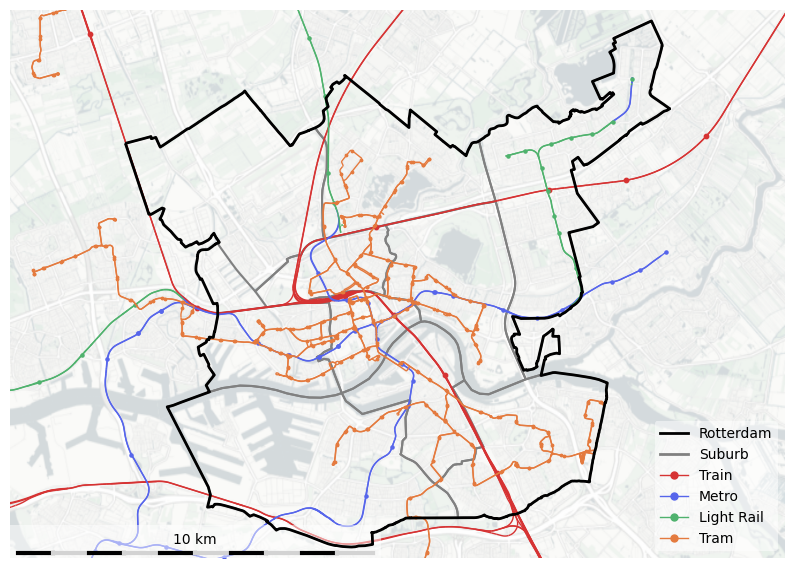

In [55]:
# Create figure
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Play area and suburbs
gdf_aoi.plot(ax=ax, facecolor='none', edgecolor=colours['aoi'], linewidth=2, zorder=3)
gdf_suburbs.plot(ax=ax, facecolor='none', edgecolor=colours['suburb'], linewidth=1.5, linestyle='-', zorder=1)

# Plot buffered area of interest and bounding box
#gdf_buffer.plot(ax=ax, facecolor='none', edgecolor="blue", linewidth=2, linestyle='--', label="Buffer", zorder=2)
#gdf_bbox.plot(ax=ax, facecolor='none', edgecolor="blue", linewidth=2, linestyle='-', label="Bounding Box", zorder=1)

# Plot train, metro, light rail, tram lines and stations
gdf_trains.plot(ax=ax, color=colours['train'], linewidth=1, markersize=10, zorder=1.1)
gdf_metros.plot(ax=ax, color=colours['metro'], linewidth=1, markersize=5, zorder=1.2)
gdf_light_rails.plot(ax=ax, color=colours['light_rail'], linewidth=1, markersize=5, zorder=1.3)
gdf_trams.plot(ax=ax, color=colours['tram'], linewidth=1, markersize=3, zorder=1.4)

# Add basemap
cx.add_basemap(ax, crs=gdf_train_lines.crs, source=cx.providers.CartoDB.PositronNoLabels, attribution=False, zoom=12)

# Add legend
ax.plot(np.nan, np.nan, color=colours['aoi'], linewidth=2, linestyle='-', label="{}".format(geocode_aoi.split(",")[0]))
ax.plot(np.nan, np.nan, color=colours['suburb'], linewidth=2, linestyle='-', label="Suburb")
#ax.plot(np.nan, np.nan, color="blue", linewidth=2, linestyle='--', label="Buffer")
#ax.plot(np.nan, np.nan, color="blue", linewidth=2, linestyle='-', label="Bounding Box")
ax.plot(np.nan, np.nan, color=colours['train'], linewidth=1, marker='o', markersize=5, label="Train")
ax.plot(np.nan, np.nan, color=colours['metro'], linewidth=1, marker='o', markersize=5, label="Metro")
ax.plot(np.nan, np.nan, color=colours['light_rail'], linewidth=1, marker='o', markersize=5, label="Light Rail")
ax.plot(np.nan, np.nan, color=colours['tram'], linewidth=1, marker='o', markersize=5, label="Tram")
ax.legend(loc='lower right', facecolor=[1, 1, 1, 1], edgecolor='none', framealpha=0.5)

# Get coordinates
from geopy.distance import geodesic
x1, y1 = bounds[0] + (bounds[2] - bounds[0]) * 0.01, bounds[1] + (bounds[3] - bounds[1]) * 0.01
x2, y2 = bounds[3] - (bounds[2] - bounds[0]) * 0.01, bounds[1] + (bounds[3] - bounds[1]) * 0.01

# Create horizontal scale on bottom left
scale_kms = 10
scale_kms_iter = 0
ratio_deg_km = 111.32
while np.abs(scale_kms - scale_kms_iter) > 0.001:
    # Get coordinates
    x1, y1 = bounds[0] + (bounds[2] - bounds[0]) * 0.01, bounds[1] + (bounds[3] - bounds[1]) * 0.01
    x2, y2 = bounds[0] + (bounds[2] - bounds[0]) * 0.01 + scale_kms * ratio_deg_km, bounds[1] + (bounds[3] - bounds[1]) * 0.01
    xoffset, yoffset = (bounds[2] - bounds[0]) * 0.01, (bounds[3] - bounds[1]) * 0.01

    # Get scale in km and ratio
    scale_kms_iter = geodesic((y1, x1), (y1, x2)).kilometers
    ratio_deg_km = (x2 - x1) / scale_kms_iter
    scale_kms_iter = geodesic((y1, x1), (y1, x2)).kilometers
    
# plot scale in alternating black and white segments
scale_step_kms = 1
for i in range(0, int(scale_kms / scale_step_kms)):
    color = "black" if i % 2 == 0 else "lightgrey"
    ax.plot([x1 + i * scale_step_kms * ratio_deg_km, x1 + (i + 1) * scale_step_kms * ratio_deg_km], [y1, y1], color=color, linewidth=3, zorder=2.1)

ax.text(x1 + scale_kms * ratio_deg_km / 2, y1+yoffset, "{} km".format(scale_kms), ha='center', va='bottom', fontsize=10)

# Add box around scale similar to legend
ax.add_patch(plt.Rectangle((x1-xoffset, y1-1*yoffset), scale_kms * ratio_deg_km + 2 * xoffset, 6 * yoffset, facecolor=[1, 1, 1, 0.5], edgecolor='none', zorder=2))

# Set limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_axis_off()
aspect = ax.get_aspect()

# Save figure
fig.savefig("map.png", bbox_inches='tight', pad_inches=0)
plt.show()

### Create dynamic map

In [56]:
# Clip to area of interest
gdf_trains = gdf_trains.clip(gdf_aoi)
gdf_metros = gdf_metros.clip(gdf_aoi)
gdf_light_rails = gdf_light_rails.clip(gdf_aoi)
gdf_trams = gdf_trams.clip(gdf_aoi)

In [58]:
# Plot all lines and stations
m = Map(location=[centre[0], centre[1]], zoom_start=12, control_scale=True, tiles='cartodb positron')

gdf_aoi.explore(m=m, style_kwds={'color': colours['aoi'], 'weight': 2, 'fillOpacity': 0}, name="{}".format(geocode_aoi.split(",")[0]), tooltip=False, popup=False, highlight=False)
gdf_suburbs.explore(m=m, style_kwds={'color': colours['suburb'], 'weight': 1.5, 'fillOpacity': 0}, name="Suburbs", tooltip=False, popup=True, highlight=False)
gdf_trains.explore(m=m, style_kwds={'color': colours['train'], 'fillColor': colours['train'], 'weight': 1, 'fillOpacity': 1, 'radius':4}, name="Train", tooltip=True, highlight=False)
gdf_metros.explore(m=m, style_kwds={'color': colours['metro'], 'fillColor': colours['metro'], 'weight': 1, 'fillOpacity': 1, 'radius':3}, name="Metro", tooltip=True, highlight=False)
gdf_light_rails.explore(m=m, style_kwds={'color': colours['light_rail'], 'fillColor': colours['light_rail'], 'weight': 1, 'fillOpacity': 1, 'radius':3}, name="Light Rail", tooltip=True, highlight=False)
gdf_trams.explore(m=m, style_kwds={'color': colours['tram'], 'fillColor': colours['tram'], 'weight': 1, 'fillOpacity': 1, 'radius':3}, name="Tram", tooltip=True, highlight=False)

# Add locate control
LocateControl(auto_start=False).add_to(m)

# Add layer control
m.add_child(LayerControl())

# Save map
m.save("map.html")

# Show map
m